# Bootstrapping For ML Researchers: A Blog Post

For years I have asked people why ML papers don't include $p$-values. Some do, of course. But it's also surprising that in a technical field, hardly anyone bothers to test their hypotheses beyond pointing out that one average is higher than another average (and then bolding some numbers).

One answer to this question is that the field of ML doesn't need $p$-values to gradually build scientific knowledge -- at least not in the same way that psychology or physics does. I think this is empirically true. Accuracy has gone up over time basically everywhere, even when many individual results are noisy.

But many ML papers do not do a good job capturing basic sources of experimental uncertainty, and this makes reading them more difficult. So, this blog post presents a case study on hypothesis testing for a single, common question in ML:

**Which of two models is more accurate at a task?** As a part of this case study, we'll aim to handle several sources of uncertainty:
1. Uncertainty due to variable test data
2. Uncertainty due to different model prompts or random seeds

## Comparing two models with a $t$-test

Suppose we want to compare Model A with Model B based on their performance on the `machine learning` [subset](https://huggingface.co/datasets/cais/mmlu/viewer/machine_learning) of MMLU. The test split of this dataset has 112 rows, so we compute model predictions for each of these points. Let's say that we get the following predictions.

In [86]:
!pip install -q datasets

import numpy as np
from datasets import load_dataset

dataset = load_dataset("tasksource/mmlu", "machine_learning")
test_data = dataset['test']
test_labels = np.array(test_data['answer'])

print("Example multiple choice question and answer:")
print("Question: ", test_data[0]['question'])
print("Answer choices: ", test_data[0]['choices'])
print("Answer: ", test_data[0]['choices'][test_labels[0]])

Example multiple choice question and answer:
Question:  Statement 1| Linear regression estimator has the smallest variance among all unbiased estimators. Statement 2| The coefficients α assigned to the classifiers assembled by AdaBoost are always non-negative.
Answer choices:  ['True, True', 'False, False', 'True, False', 'False, True']
Answer:  False, True


In [87]:
def create_array_with_accuracy(labels, accuracy, rng, eps=0):
    # function to create hypothetical model preds. eps is random noise in absolute # correct
    n = len(labels)
    n_correct = int(n * accuracy)
    if eps > 0:
      adjust_n_correct = int(rng.uniform(-eps, eps+1))
      n_correct = n_correct + adjust_n_correct
      n_correct = min(n, n_correct)
      n_correct = max(0, n_correct)
    n_incorrect = n - n_correct
    new_array = labels.copy()
    indices_to_change = rng.choice(n, n_incorrect, replace=False)
    for idx in indices_to_change:
        possible_labels = [0, 1, 2, 3]
        possible_labels.remove(labels[idx])
        new_array[idx] = rng.choice(possible_labels)
    return new_array

# Create arrays A and B
rng = np.random.default_rng(0)
model_A_preds = create_array_with_accuracy(test_labels, 0.97, rng, eps=0)
model_B_preds = create_array_with_accuracy(test_labels, 0.91, rng, eps=0)

print("Test labels:", test_labels)
print(f"Model A acc: {np.mean(model_A_preds==test_labels):.3f}")
print(f"Model B acc: {np.mean(model_B_preds==test_labels):.3f}")

Test labels: [3 2 1 3 0 1 0 1 2 0 0 2 0 1 1 1 2 0 0 0 2 0 1 2 1 0 1 2 3 2 2 2 1 3 0 3 3
 1 1 0 0 2 1 1 3 0 3 0 3 3 1 0 3 2 0 3 3 3 1 1 1 0 2 1 0 2 2 0 0 0 0 0 1 3
 2 1 2 0 1 3 0 2 1 0 2 0 0 2 2 0 2 1 1 1 1 0 0 2 1 3 1 0 1 2 0 1 2 1 3 2 0
 2]
Model A acc: 0.964
Model B acc: 0.902


Let's first compare these two model accuracies with a $t$-test. We will use a [paired test](https://en.wikipedia.org/wiki/Paired_difference_test) for this, since the same datapoints are used across models. This test relies on the distribution of the $t$ statistic, and can be executed by scipy. We will also compute 95% confidence intervals for the model accuracies with [Wilson scores](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval#Wilson_score_interval). Wilson score confidence intervals have the nice property that they won't spill over outside of 0-1.

In [88]:
from scipy import stats
import statsmodels.stats.proportion as smp

In [89]:
model_A_accs = 1*(model_A_preds == test_labels)
model_B_accs = 1*(model_B_preds == test_labels)
n = len(model_A_accs)

A_CI = smp.proportion_confint(sum(model_A_accs), n, alpha=0.05, method='wilson')
A_CI = [round(x,4) for x in A_CI]
B_CI = smp.proportion_confint(sum(model_B_accs), n, alpha=0.05, method='wilson')
B_CI = [round(x,4) for x in B_CI]
t_statistic, p_value = stats.ttest_rel(model_A_accs, model_B_accs)

print(f"Model A acc: {np.mean(model_A_preds==test_labels):.3f}")
print(f"A acc 95% CI: {A_CI}")
print(f"Model B acc: {np.mean(model_B_preds==test_labels):.3f}")
print(f"B acc 95% CI: {B_CI}")
print(f"p-value: {p_value:.4f}")
print(f"n points: {len(test_labels)}")

Model A acc: 0.964
A acc 95% CI: [0.9118, 0.986]
Model B acc: 0.902
B acc 95% CI: [0.8327, 0.9443]
p-value: 0.0518
n points: 112


Bummer, our 6.2 point improvement of model A over model B isn't statistically significant at threshold of 0.05. At least an effect size of 6.2 for MMLU data is meaningful, and many people would interpret this result as promising (if it were not hypothetical).

## Bootstrapping instead of a $t$-test

What's the difference between a $t$-test and bootstrapping?

Bootstrapping is a non-parametric test that relies on data resampling rather than exact (analytical) math for the test. It works by **simulating the data generation process** in order to get an estimate of the variance of that data generation process. Specifically, we simulate the data generation process by *resampling from the data we already have*. This looks like the pipeline below:

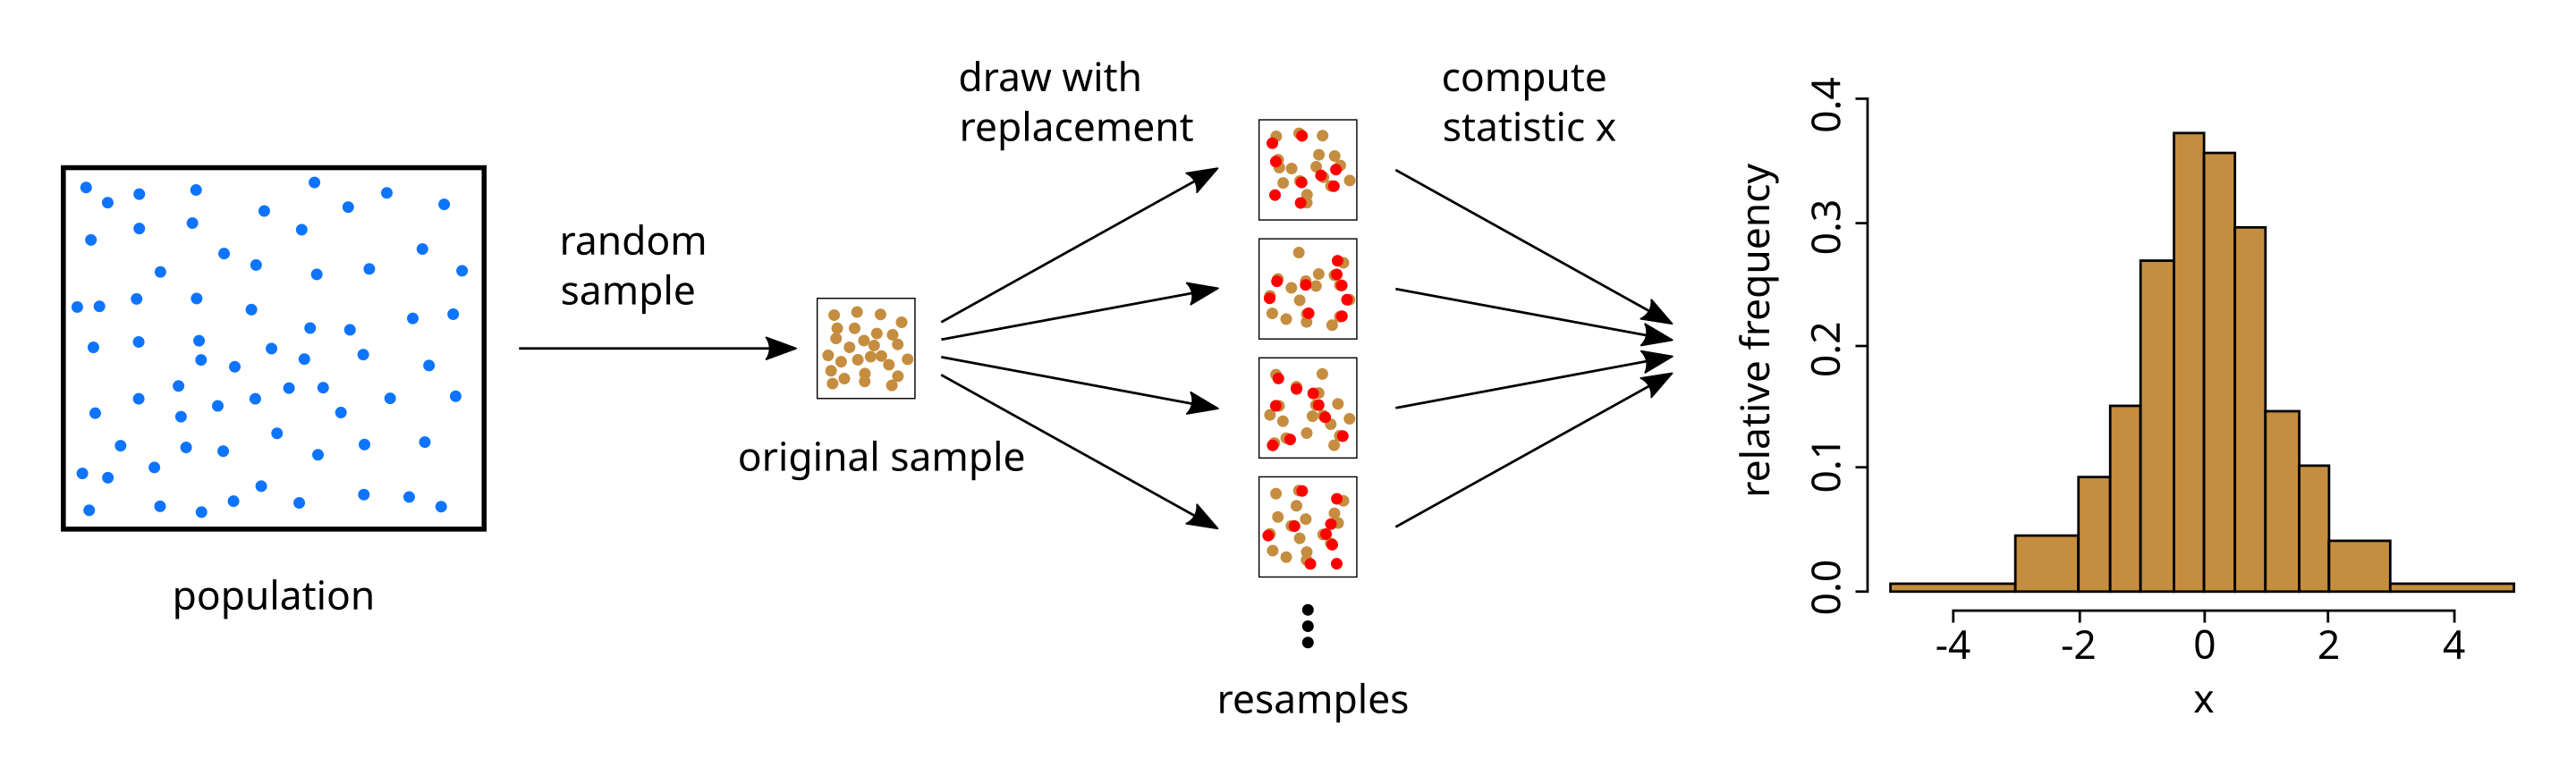

([image from Wikipedia](https://en.wikipedia.org/wiki/Bootstrapping_%28statistics%29))

Bootstrapping can be better with small sample sizes and skewed data distributions by virtue of being less biased, although it won't necessarily produce tighter CIs.

We'll see more advantages of the bootstrap later, but let's try a simple bootstrap test now.

In [90]:
def get_p_value(betas):
    # calculate p-value for two-sided difference from 0 test with a bootstrapped distribution of statistics, betas
    abs_mean_beta = np.abs(np.mean(betas))
    centered_betas = betas - np.mean(betas)
    outside_prop = np.mean(centered_betas < -abs_mean_beta) + np.mean(centered_betas > abs_mean_beta)
    return outside_prop

def bootstrap_1darray(samples, rng, n_resamples=100000):
    # resamples an array n_resamples times, returning the list of means of each resample
    samples = np.array(samples)
    bootstrap_means = np.zeros(n_resamples)
    for i in range(n_resamples):
        # print progress
        if n_resamples > 100000:
            if i % 10000 == 0:
                print(f"Progress={i/n_resamples*100:.0f}%")
        resampled = rng.choice(samples, size=len(samples), replace=True)
        bootstrap_means[i] = np.mean(resampled)
    return bootstrap_means

def summarize_bootstrap(bootstrap_means):
    # compute mean and 95th credible interval based on bootstrap_means
    bootstrap_mean = np.mean(bootstrap_means)
    ci_lower, ci_upper = np.percentile(bootstrap_means, [2.5, 97.5])
    clean_CI = (round(ci_lower.item(), 4), round(ci_upper.item(), 4))
    return bootstrap_mean, clean_CI

In [91]:
rng = np.random.default_rng(0)
n_resamples = 100000 # we'll use 100k samples. To get maximally stable results across random seeds, you might need ~1m samples

# first we get estimates of each model accuracy independently
A_bootstrap_means = bootstrap_1darray(model_A_accs, rng=rng, n_resamples=n_resamples)
B_bootstrap_means = bootstrap_1darray(model_B_accs, rng=rng, n_resamples=n_resamples)
A_mean, A_CI = summarize_bootstrap(A_bootstrap_means)
B_mean, B_CI = summarize_bootstrap(B_bootstrap_means)

# then we estimate the difference between model accuracies
pointwise_acc_diffs = model_A_accs - model_B_accs
diff_means = bootstrap_1darray(samples=pointwise_acc_diffs, rng=rng, n_resamples=n_resamples)
p_value = get_p_value(diff_means)
diffs_mean, diffs_CI = summarize_bootstrap(diff_means)

print(f"Model A acc: {np.mean(model_A_preds==test_labels):.3f}")
print(f"Model A bootstrap result: mean = {A_mean:.3f} | CI = {A_CI}")
print(f"Model B acc: {np.mean(model_B_preds==test_labels):.3f}")
print(f"Model B bootstrap result: mean = {B_mean:.3f} | CI = {B_CI}")
print()
print(f"Diff estimate: {diffs_mean:.3f} | CI = {diffs_CI}")
print(f"p-value: {p_value:.4f}")

Model A acc: 0.964
Model A bootstrap result: mean = 0.964 | CI = (0.9286, 0.9911)
Model B acc: 0.902
Model B bootstrap result: mean = 0.902 | CI = (0.8482, 0.9554)

Diff estimate: 0.062 | CI = (0.0, 0.125)
p-value: 0.0505


These numbers are pretty similar to the $t$-test! But they took longer to get. So what is the point of using a bootstrap? Well, that comes in next.

## Bootstrapping for experiments with TWO sources of variance

**Most statistical tests only account for one source of variance**, such as variance from the test data as we considered above.

But **it is common that ML experiments have multiple sources of randomness**. In deep learning, different training runs usually lead to different results. And in the era of prompting LLMs, we may use different prompting data or different prompt templates.

The great strength of the bootstrap is that a method called **[block bootstrapping](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)#Block_bootstrap) allows you to handle two sources of uncertainty at once**, like test variance and seed variance.

Here's an example. I have a fixed train and test set, and I want to communicate how good Model A is when using in-context learning with $k=5$ examples. Now, we have two sources of uncertainty:
1. Does our train (ICL) data reflect the broader data distribution?
2. Does our test data reflect the broader data distribution?

In theory, analytic testing can answer both of these questions once, but good luck finding code for this online.

Yet bootstrapping can handle this case easily! Here's how: we want to form a grid of model accuracies, where rows represent datapoints and columns represent different prompts.

Let's create a matrix representing model predictions with **three random prompts** below.

In [92]:
rng = np.random.default_rng(3)
model_A_prompt_one_preds = create_array_with_accuracy(test_labels, 0.96, rng, eps=5)
model_A_prompt_two_preds = create_array_with_accuracy(test_labels, 0.96, rng, eps=5)
model_A_prompt_three_preds = create_array_with_accuracy(test_labels, 0.96, rng, eps=5)
model_A_prompt_one_accs = model_A_prompt_one_preds == test_labels
model_A_prompt_two_accs = model_A_prompt_two_preds == test_labels
model_A_prompt_three_accs = model_A_prompt_three_preds == test_labels
print(f"model A prompt one acc:   {np.mean(model_A_prompt_one_accs):.3f}")
print(f"model A prompt two acc:   {np.mean(model_A_prompt_two_accs):.3f}")
print(f"model A prompt three acc: {np.mean(model_A_prompt_three_accs):.3f}")

model_A_accs = 1 * np.array([model_A_prompt_one_accs, model_A_prompt_two_accs, model_A_prompt_three_accs]).T
print("model A accs grid shape:", model_A_accs.shape)
print("112 data points, 3 random prompts -- each cell is 0/1 meaning incorrect/correct")

model A prompt one acc:   0.920
model A prompt two acc:   0.982
model A prompt three acc: 0.973
model A accs grid shape: (112, 3)
112 data points, 3 random prompts -- each cell is 0/1 meaning incorrect/correct


Now when we're resampling the accuracies in the bootstrap, we resample both rows *and* columns of this matrix.

This process **simulates the data generation process**:
- First, we simulate drawing different random prompts from the prompt distribution
- Second, we simulate drawing different test datapoints from test data distribution

In [93]:
def bootstrap_2dmatrix(matrix, rng, n_resamples=100000):
    # resamples a 2D matrix n_resamples times, resampling both rows and columns
    matrix = np.array(matrix)
    n_rows, n_cols = matrix.shape
    bootstrap_means = np.zeros(n_resamples)
    for i in range(n_resamples):
        resampled_rows = rng.choice(n_rows, size=n_rows, replace=True)
        resampled_cols = rng.choice(n_cols, size=n_cols, replace=True)
        resampled_matrix = matrix[resampled_rows][:, resampled_cols]
        bootstrap_means[i] = np.mean(resampled_matrix)
    return bootstrap_means

How can we use this to **compare model A and B?** As so:

In [94]:
# make hypothetical model B data
rng = np.random.default_rng(7)
model_B_prompt_one_preds = create_array_with_accuracy(test_labels, 0.91, rng, eps=5)
model_B_prompt_two_preds = create_array_with_accuracy(test_labels, 0.91, rng, eps=5)
model_B_prompt_three_preds = create_array_with_accuracy(test_labels, 0.91, rng, eps=5)
model_B_prompt_one_accs = model_B_prompt_one_preds == test_labels
model_B_prompt_two_accs = model_B_prompt_two_preds == test_labels
model_B_prompt_three_accs = model_B_prompt_three_preds == test_labels
print(f"model A prompt one acc:   {np.mean(model_A_prompt_one_accs):.3f}")
print(f"model A prompt two acc:   {np.mean(model_A_prompt_two_accs):.3f}")
print(f"model A prompt three acc: {np.mean(model_A_prompt_three_accs):.3f}")
print(f"model B prompt one acc:   {np.mean(model_B_prompt_one_accs):.3f}")
print(f"model B prompt two acc:   {np.mean(model_B_prompt_two_accs):.3f}")
print(f"model B prompt three acc: {np.mean(model_B_prompt_three_accs):.3f}")

model_B_accs = 1* np.array([model_B_prompt_one_accs, model_B_prompt_two_accs, model_B_prompt_three_accs]).T

model A prompt one acc:   0.920
model A prompt two acc:   0.982
model A prompt three acc: 0.973
model B prompt one acc:   0.911
model B prompt two acc:   0.946
model B prompt three acc: 0.902


In [95]:
rng = np.random.default_rng(0)

# estimate performance of model A and model B separately
model_A_boot_means = bootstrap_2dmatrix(model_A_accs, rng)
model_B_boot_means = bootstrap_2dmatrix(model_B_accs, rng)
A_mean, A_CI = summarize_bootstrap(model_A_boot_means)
B_mean, B_CI = summarize_bootstrap(model_B_boot_means)

# estimate difference in model performance
diff_means = bootstrap_2dmatrix(model_A_accs - model_B_accs, rng)
diffs_mean, diffs_CI = summarize_bootstrap(diff_means)
p_value = get_p_value(diff_means)

print("Block bootstrapping approach:")
print(f"Model A acc: {np.mean(model_A_accs):.3f}")
print(f"Model A bootstrap result: mean = {A_mean:.3f} | CI = {A_CI}")
print(f"Model B acc: {np.mean(model_B_accs):.3f}")
print(f"Model B bootstrap result: mean = {B_mean:.3f} | CI = {B_CI}")
print()
print(f"Diffs mean: {diffs_mean:.3f} | CI = {diffs_CI}")
print(f"p-value for difference in models: {p_value:.4f}")

Block bootstrapping approach:
Model A acc: 0.958
Model A bootstrap result: mean = 0.958 | CI = (0.9107, 0.9911)
Model B acc: 0.920
Model B bootstrap result: mean = 0.920 | CI = (0.875, 0.9613)

Diffs mean: 0.039 | CI = (-0.0179, 0.0923)
p-value for difference in models: 0.1432


Look at that! We have CIs for each model performance, along with a $p$-value comparing the two models, all while accounting for both test data variance and the "prompt" variance, representing variance in the training data used in the prompt.

I think this kind of **block bootstrapping is much better than**:
- **averaging across test data and reporting seed variance (common in the literature)**
- **averaging across seeds and reporting test data variance (not as common)**

To illustrate this, below we can compare our bootstrap results to these two alternatives, which will both underestimate total variance.

In [96]:
rng = np.random.default_rng(0)

# alternative 1: average across test data, report seed variance
A_seed_means = np.mean(model_A_accs, axis=0)
B_seed_means = np.mean(model_B_accs, axis=0)
print("Alternative 1: average across test data, report seed variance")
print(f"A acc: {np.mean(model_A_accs):.3f} w/ std error bar: {np.std(A_seed_means):.4f}")
print(f"B acc: {np.mean(model_B_accs):.3f} w/ std error bar: {np.std(B_seed_means):.4f}")
print(f"This does not give us a p-value! We have to use our intuition based on the std errors")

# alternative 2: average across seeds, report test data variance
A_data_means = np.mean(model_A_accs, axis=1)
B_data_means = np.mean(model_B_accs, axis=1)
A_bootstrap_means = bootstrap_1darray(A_data_means, rng=rng)
B_bootstrap_means = bootstrap_1darray(B_data_means, rng=rng)
A_mean, A_CI = summarize_bootstrap(A_bootstrap_means)
B_mean, B_CI = summarize_bootstrap(B_bootstrap_means)
pointwise_acc_diffs = A_data_means - B_data_means
diff_means = bootstrap_1darray(samples=pointwise_acc_diffs, rng=rng)
diffs_mean, diffs_CI = summarize_bootstrap(diff_means)
p_value = get_p_value(diff_means)

print()
print("Alternative 2: average across seeds, report test data variance")
print(f"Model A: mean = {A_mean:.3f} | CI = {A_CI}")
print(f"Model B: mean = {B_mean:.3f} | CI = {B_CI}")
print(f"Diffs mean: {diffs_mean:.3f} | CI = {diffs_CI}")
print(f"p-value for difference in models: {p_value:.4f} -- SIGNIFICANT UNDERESTIMATE OF VARIANCE")


Alternative 1: average across test data, report seed variance
A acc: 0.958 w/ std error bar: 0.0276
B acc: 0.920 w/ std error bar: 0.0193
This does not give us a p-value! We have to use our intuition based on the std errors

Alternative 2: average across seeds, report test data variance
Model A: mean = 0.958 | CI = (0.9375, 0.9762)
Model B: mean = 0.920 | CI = (0.8899, 0.9464)
Diffs mean: 0.039 | CI = (0.003, 0.0744)
p-value for difference in models: 0.0235 -- SIGNIFICANT UNDERESTIMATE OF VARIANCE


Notice that ignoring seed variance gives a p value of .02, compared to the value of .14 that our block bootstrap gave. Meanwhile, ignoring test data variance makes it look like we have a 3.8 point improvement that might overcome the seed variance (though it's hard to tell with 3 samples). Both of these approaches significantly underestimates noise in our experiment.

**What else is the block bootstrap useful for?** Using block bootstraps, we can compare model with many different sources of variance:
1. Test data
2. Train/prompt data
3. Training seed, for finetuning
4. Prompt template (selected randomly from a distribution)
5. Other "sampled" or "random" experiment parameters

In fact, if we see variance from multiple such sources at once, we can go beyond our 2D example and construct n-D arrays and block bootstrap over those. All we have to do is use the same indices when sampling each dimension of the input data.

## Bootstrapping for grouped questions

In our block bootstrap, we have a grid of data. Now we consider a setting with **hierarchically grouped data**. For example, our test set might have questions based on documents, where the dataset is based on a smaller number of documents with multiple questions per document. See related discussion about clustered questions in this [Anthropic blog post](https://www.anthropic.com/research/statistical-approach-to-model-evals).

Here, we use a **hierarchical bootstrap** that simulates the data generation process by:
- resampling the highest grouping (e.g., document level)
- then resampling the lower level grouping (e.g., question level)

See example below.



In [105]:
# data setup. We will make a dataframe with a document_id variable

import pandas as pd

# we'll pretend our 112 accuracies are for 8 underlying documents
questions_per_document = len(test_data) / 8
document_ids = [int(i // questions_per_document) for i in range(len(test_data))]

# make model preds, one set for model A and one set for model B
rng = np.random.default_rng(0)
model_A_preds = create_array_with_accuracy(test_labels, 0.97, rng, eps=0)
model_A_accs = 1*(model_A_preds == test_labels)
model_B_preds = create_array_with_accuracy(test_labels, 0.89, rng, eps=0)
model_B_accs = 1*(model_B_preds == test_labels)

# we will artifically create a correlation between the group id and the correctness by sorting the correctness values
model_A_accs = np.array(sorted(model_A_accs))

print(f"Model A acc: {np.mean(model_A_accs):.3f}")
print(f"Model B acc: {np.mean(model_B_accs):.3f}")

accuracy_df = pd.DataFrame({
      'document_id': document_ids,
      'model_A_acc': model_A_accs,
      'model_B_acc': model_B_accs,
    })
print(accuracy_df)

Model A acc: 0.964
Model B acc: 0.884
     document_id  model_A_acc  model_B_acc
0              0            0            0
1              0            0            1
2              0            0            1
3              0            0            1
4              0            1            1
..           ...          ...          ...
107            7            1            1
108            7            1            1
109            7            1            1
110            7            1            1
111            7            1            1

[112 rows x 3 columns]


In [106]:
# define the hierarchical bootstrap function
def hierarchical_bootstrap(data, rng, target_var, grouping_var_name='document_id', n_resamples=100000):
    unique_group_ids = np.unique(data[grouping_var_name])
    boot_means = []
    for i in range(n_resamples):
        # print progress -- this one will be a little slow
        if n_resamples >= 10000:
            if i % 5000 == 0:
                print(f"Progress={i/n_resamples*100:.0f}%")
        resample_group_ids = rng.choice(unique_group_ids, size=len(unique_group_ids), replace=True)
        # first resample group ids
        group_id_and_num_repetitions = [(group_id.item(), sum(resample_group_ids==group_id).item()) for group_id in np.unique(resample_group_ids)]
        # for each group id in our simulated sample, we will resample datapoints that belong to that group id
        # note that if our resample_group_ids contains the same id twice, we use the same resampled points belonging to that group twice (hence the counting above)
        collect_boot_data = []
        for group_id, group_id_num_reps in group_id_and_num_repetitions:
          group_subset = data[data[grouping_var_name] == group_id]
          row_ids = rng.choice(np.arange(len(group_subset)), size=len(group_subset), replace=True)
          resampled_group_subset = group_subset.iloc[row_ids]
          # get the target variable here, the thing we are estimating
          resampled_group_subset = group_subset[target_var]
          repeated_resampled_group_subset = np.repeat(resampled_group_subset, group_id_num_reps)
          collect_boot_data.append(repeated_resampled_group_subset)
        # now get one resampled df for this iteration
        boot_data = np.concatenate(collect_boot_data)
        boot_means.append(np.mean(boot_data))
    return boot_means


Now we will compare a regular 1-d bootstrap with the hierarchical bootstrap.

In [107]:
rng = np.random.default_rng(0)
n_resamples = 10000

print("WITH HIERARCHICAL RESAMPLING")
A_bootstrap_means = hierarchical_bootstrap(accuracy_df,
                                           rng=rng,
                                           target_var='model_A_acc',
                                           grouping_var_name='document_id',
                                           n_resamples=n_resamples)
B_bootstrap_means = hierarchical_bootstrap(accuracy_df,
                                           rng=rng,
                                           target_var='model_B_acc',
                                           grouping_var_name='document_id',
                                           n_resamples=n_resamples)
A_mean, A_CI = summarize_bootstrap(A_bootstrap_means)
B_mean, B_CI = summarize_bootstrap(B_bootstrap_means)
# add pointwise acc diffs column to df
accuracy_df['acc_diff'] = accuracy_df['model_A_acc'] - accuracy_df['model_B_acc']
diff_means = hierarchical_bootstrap(accuracy_df,
                                    rng=rng,
                                    target_var='acc_diff',
                                    grouping_var_name='document_id',
                                    n_resamples=n_resamples)
p_value = get_p_value(diff_means)
diffs_mean, diffs_CI = summarize_bootstrap(diff_means)

print(f"Model A acc: {np.mean(model_A_preds==test_labels):.3f}")
print(f"Model A bootstrap result: mean = {A_mean:.3f} | CI = {A_CI}")
print(f"Model B acc: {np.mean(model_B_preds==test_labels):.3f}")
print(f"Model B bootstrap result: mean = {B_mean:.3f} | CI = {B_CI}")
print(f"Diff estimate: {diffs_mean:.3f} | CI = {diffs_CI}")
print(f"p-value: {p_value:.4f}")

print()
print("WITHOUT HIERARCHICAL RESAMPLING")
A_bootstrap_means = bootstrap_1darray(model_A_accs, rng=rng, n_resamples=n_resamples)
B_bootstrap_means = bootstrap_1darray(model_B_accs, rng=rng, n_resamples=n_resamples)
A_mean, A_CI = summarize_bootstrap(A_bootstrap_means)
B_mean, B_CI = summarize_bootstrap(B_bootstrap_means)
pointwise_acc_diffs = model_A_accs - model_B_accs
diff_means = bootstrap_1darray(samples=pointwise_acc_diffs, rng=rng, n_resamples=n_resamples)
p_value = get_p_value(diff_means)
diffs_mean, diffs_CI = summarize_bootstrap(diff_means)

print(f"Model A acc: {np.mean(model_A_preds==test_labels):.3f}")
print(f"Model A bootstrap result: mean = {A_mean:.3f} | CI = {A_CI}")
print(f"Model B acc: {np.mean(model_B_preds==test_labels):.3f}")
print(f"Model B bootstrap result: mean = {B_mean:.3f} | CI = {B_CI}")
print(f"Diff estimate: {diffs_mean:.3f} | CI = {diffs_CI}")
print(f"p-value: {p_value:.4f}")

WITH HIERARCHICAL RESAMPLING
Progress=0%
Progress=50%
Progress=0%
Progress=50%
Progress=0%
Progress=50%
Model A acc: 0.964
Model A bootstrap result: mean = 0.964 | CI = (0.8929, 1.0)
Model B acc: 0.884
Model B bootstrap result: mean = 0.884 | CI = (0.8214, 0.9375)
Diff estimate: 0.080 | CI = (-0.0179, 0.1696)
p-value: 0.0914

WITHOUT HIERARCHICAL RESAMPLING
Model A acc: 0.964
Model A bootstrap result: mean = 0.964 | CI = (0.9286, 0.9911)
Model B acc: 0.884
Model B bootstrap result: mean = 0.883 | CI = (0.8214, 0.9375)
Diff estimate: 0.081 | CI = (0.0179, 0.1518)
p-value: 0.0123


Notice how **these approaches give different results!**

Because the hierarchical bootstrap correctly captures the variance between data clusters (the document ids), the estimates for the hierarchical bootstrap show higher variance than the naive bootstrap estimate.

# Conclusion



That's it for an intro to bootstrapping for ML experiments. While there are a few variations of the bootstrap that are appropriate for different situations, **my number one recommendation is to block bootstrap across test data and random seed when estimating or comparing model performance**. If random seed accounts for random prompts, random model training, or other randomness in the experiment, this will be a great way to account for both test data noise and other random experiment noise.

I wrote the code in this post, but keep in mind that there are also existing libraries with more prepackaged functions for bootstrapping, like `scipy.stats.bootstrap `, though I can't speak to its flexibility.

# Addendum: Can we tune the random seed?

Test data is test data -- it can't be tuned. But we might want to showcase that one LLM can make better use of $k=5$ points than another LLM can. In this case, we're not just going to randomly select 5 prompt points, but instead we might carefully craft the examples to maximize model performance.

A similar argument applies, though less forcefully, to other aspects of experiment design like the prompt template or random seed. For instance, we can give someone a well-performing prompt template in the hope that they get the exact same performance we did. We could also give someone the exact data ordering used during finetuning (determined by the random seed). But it starts to make less sense as a "tuning" decision when we are tuning uninterpretable hyperparameters that are hard to replicate across different machines.  

Anyhow, what should we do in this situation? We could take the very best prompt we have, and then look at the 1D array of test accuracies this prompt+model combination gives us -- this puts us back in $t$-test or 1-D bootstrap territory. But what are we actually trying to estimate here? Classically, we estimate the expected model accuracy:

$$E_{x,y\sim D} [f_\theta(x) = y]$$

We could tune the prompt as we estimate this quantity, just as we tune other model hyperparameters. But we could also estimate the quantity

$$max_{prompt} \ \ E_{x,y\sim D} [f_\theta(x; {prompt}) = y]$$

treating $prompt$ as a random variable. The reason for this is that if we are pitching an ML method that people are interested in applying to other tasks, they will not use the same prompt, but they might also tune the prompt in their setting. Therefore, we may want to give them an estimate of what the *best performing* prompt could yield, while accounting for the uncertainty in determining what the best prompt is with a limited number of attempts.

That all said, here's what I would do in this situation:

In [100]:
def bootstrap_matrix_max_prompt(matrix, rng, n_prompt_attempts, n_resamples=100000):
    # estimates mean test performance for the best performing prompt out of n_tested_prompts
    # NOTE matrix.shape[1] (n_col) is ideally larger than n_tested prompts, or otherwise this is kind of like a sample size 1 test
    matrix = np.array(matrix)
    n_rows, n_cols = matrix.shape
    bootstrap_means = np.zeros(n_resamples)
    for i in range(n_resamples):
        resampled_rows = rng.choice(n_rows, size=n_rows, replace=True)
        resampled_cols = rng.choice(n_cols, size=n_prompt_attempts, replace=True) # we will select n_prompt_attempts columns, to replicate the process of someone trying n_prompt_attempts prompts
        resampled_matrix = matrix[resampled_rows][:, resampled_cols]
        resampled_col_accs = np.mean(resampled_matrix, axis=0)
        best_col_idx = np.argmax(resampled_col_accs) # now we select the best prompt based on this resampled data
        best_prompt_resampled_matrix = resampled_matrix[:,best_col_idx] # then we estimate the test data accuracy of the best prompt
        bootstrap_means[i] = np.mean(best_prompt_resampled_matrix)
    return bootstrap_means

In [103]:
rng = np.random.default_rng(1)
model_A_prompt_one_preds = create_array_with_accuracy(test_labels, 0.9, rng, eps=10)
model_A_prompt_two_preds = create_array_with_accuracy(test_labels, 0.9, rng, eps=10)
model_A_prompt_three_preds = create_array_with_accuracy(test_labels, 0.9, rng, eps=10)
model_A_prompt_four_preds = create_array_with_accuracy(test_labels, 0.9, rng, eps=10)
model_A_prompt_five_preds = create_array_with_accuracy(test_labels, 0.9, rng, eps=10)
model_A_prompt_one_accs = model_A_prompt_one_preds == test_labels
model_A_prompt_two_accs = model_A_prompt_two_preds == test_labels
model_A_prompt_three_accs = model_A_prompt_three_preds == test_labels
model_A_prompt_four_accs = model_A_prompt_four_preds == test_labels
model_A_prompt_five_accs = model_A_prompt_five_preds == test_labels
print(f"model A prompt one acc: {np.mean(model_A_prompt_one_accs):.4f}")
print(f"model A prompt two acc: {np.mean(model_A_prompt_two_accs):.4f}")
print(f"model A prompt three acc: {np.mean(model_A_prompt_three_accs):.4f}")
print(f"model A prompt four acc: {np.mean(model_A_prompt_four_accs):.4f}")
print(f"model A prompt five acc: {np.mean(model_A_prompt_five_accs):.4f}")

model_A_accs = 1 * np.array([model_A_prompt_one_accs, model_A_prompt_two_accs, model_A_prompt_three_accs, model_A_prompt_four_accs, model_A_prompt_five_accs]).T
print("model A accs grid shape:", model_A_accs.shape)

model_A_boot_means = bootstrap_2dmatrix(model_A_accs, rng)
A_mean, A_CI = summarize_bootstrap(model_A_boot_means)
A_CI = [round(x,4) for x in A_CI]

print()
print("ORIGINAL block bootstrap, treating all five tested prompts as samples from a prompt distribution")
print(f"Model A acc: {np.mean(model_A_accs):.3f}")
print(f"Model A bootstrap result: mean = {A_mean:.3f} | CI = {A_CI}")

n_prompt_tests = 3
model_A_boot_means = bootstrap_matrix_max_prompt(model_A_accs, rng, n_prompt_attempts=n_prompt_tests)
A_mean, A_CI = summarize_bootstrap(model_A_boot_means)
A_CI = [round(x,4) for x in A_CI]
best_col = np.argmax(np.mean(model_A_accs,axis=0))
best_col_mean = np.mean(model_A_accs[:, best_col])

print()
print(f"Block bootstrap for estimating max_prompt ExpectedAcc")
# print(f"Model A (best prompt) acc: {best_col_mean:.3f}") -- don't print this bc it doesn't make sense as a point estimate bc it's best of 5, while we're estimating best of 3
print(f"Model A bootstrap result: mean = {A_mean:.3f} | CI = {A_CI}")

best_col = np.argmax(np.mean(model_A_accs,axis=0))
model_A_boot_means = bootstrap_1darray(model_A_accs[:,best_col], rng)
A_mean, A_CI = summarize_bootstrap(model_A_boot_means)
A_CI = [round(x,4) for x in A_CI]
best_col_mean = np.mean(model_A_accs[:, best_col])

print()
print("Bootstrap for estimating ExpectedAcc of the best of our five tested prompts (i.e., we use our own 'tuned prompt', the best of our five prompts)")
print(f"Model A (best prompt) acc: {best_col_mean:.3f}")
print(f"Model A bootstrap result: mean = {A_mean:.3f} | CI = {A_CI}")


model A prompt one acc: 0.8929
model A prompt two acc: 0.8571
model A prompt three acc: 0.8571
model A prompt four acc: 0.9464
model A prompt five acc: 0.9732
model A accs grid shape: (112, 5)

ORIGINAL block bootstrap, treating all five tested prompts as samples from a prompt distribution
Model A acc: 0.905
Model A bootstrap result: mean = 0.905 | CI = [0.8518, 0.9536]

Block bootstrap for estimating max_prompt ExpectedAcc
Model A bootstrap result: mean = 0.948 | CI = [0.8571, 0.9911]

Bootstrap for estimating ExpectedAcc of the best of our five tested prompts (i.e., we use our own 'tuned prompt', the best of our five prompts)
Model A (best prompt) acc: 0.973
Model A bootstrap result: mean = 0.973 | CI = [0.9375, 1.0]


Notice that "tuning" the prompt (last result) gives an overly optimistic picture of model accuracy for someone who tries three prompts and then picks the best one (middle result), and both of estimates are higher than simply taking the mean performance across prompts.

*Disclaimer*: I'm sure there are insights from extreme value theory that would also be relevant to this problem, but I'm not very familiar with the area.

# Acknowledgements

Thanks to Miles Turpin for helpful comments on this post.